<a href="https://colab.research.google.com/github/meti-94/CodingQuestions/blob/main/Predictive%20Analysis/SHAP/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle -q
!pip install shap -q
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d williamscott701/memotion-dataset-7k

100% 694M/695M [00:32<00:00, 22.1MB/s]
100% 695M/695M [00:32<00:00, 22.2MB/s]


In [5]:
!unzip -qq /content/memotion-dataset-7k.zip

In [19]:
from transformers import BertTokenizer, BertModel, pipeline
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import pandas as pd
import numpy as np
import shap
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
df = pd.read_csv('/content/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.head()

image_name                                           text_ocr  \
0   image_1.jpg  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  image_2.jpeg  The best of #10 YearChallenge! Completed in le...   
2   image_3.JPG  Sam Thorne @Strippin ( Follow Follow Saw every...   
3   image_4.png              10 Year Challenge - Sweet Dee Edition   
4   image_5.png  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

                                      text_corrected      humour  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   hilarious   
1  The best of #10 YearChallenge! Completed in le...   not_funny   
2  Sam Thorne @Strippin ( Follow Follow Saw every...  very_funny   
3              10 Year Challenge - Sweet Dee Edition  very_funny   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   hilarious   

           sarcasm       offensive      motivational overall_sentiment  
0          general   not_offensive  not_motivational     very_positive  
1          general   not_offensive      motivational     very_positive  
2    not_sarcastic   not_offensive  not_motivational          positive  
3  twisted_meaning  very_offensive      motivational          positive  
4     very_twisted  very_offensive  not_motivational           neutral

In [8]:
clean_df = df.copy()
clean_df.dropna(inplace=True)
clean_df.isnull().any()

image_name           False
text_ocr             False
text_corrected       False
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

In [9]:
df = df.replace({'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1},
            'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}})

In [10]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg',
              'image_1567.jpg',
              'image_6357.jpg',
              'image_5119.png',
              'image_6882.png', 
              'image_4924.jpg',
              'image_5580.png']

In [11]:
cleaner_df = df
for images in rows_to_drop:
    cleaner_df.drop(cleaner_df[cleaner_df['image_name'] == images].index, inplace=True)
cleaner_df.to_csv('/content/memotion_dataset_7k/cleaned_labels.csv')

In [11]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

In [12]:
mapping = {'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1},
            'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}}

class MemesImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, label_index=4, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        # self.img_labels = self.img_labels.replace(mapping)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_index = label_index
        self.onehot = torch.randint(0, 10, (10,))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, self.label_index]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if image.size()[0]==1:
          image = image.expand(3, 28, 28)
        if image.size()[0]==4:
          image = image[:3, :, :]
        label = torch.nn.functional.one_hot(torch.tensor(label), num_classes=4)
        return torch.mean(image.to(torch.float32), 0, True), label
        

In [13]:
meme_ds = MemesImageDataset('/content/memotion_dataset_7k/cleaned_labels.csv', '/content/memotion_dataset_7k/images', label_index=4, transform=transforms.Resize((28, 28)))

In [14]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(meme_ds, [0.8, 0.1, 0.1])

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [16]:
l = nn.CrossEntropyLoss()

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 4),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = l(output, torch.argmax(target, dim=1))
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += l(output, torch.argmax(target, dim=1)).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(torch.argmax(target, dim=1).view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [18]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [19]:
for epoch in range(1, num_epochs + 1):
 
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

Train Epoch: 1 [0/5581 (0%)]	Loss: 1.404372

Test set: Average loss: 0.0122, Accuracy: 231/697 (33%)

Train Epoch: 2 [0/5581 (0%)]	Loss: 1.437090

Test set: Average loss: 0.0122, Accuracy: 231/697 (33%)



In [20]:
batch = next(iter(test_dataloader))
images, _ = batch

background = images[:100]
test_images = images[100:103]


e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [21]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

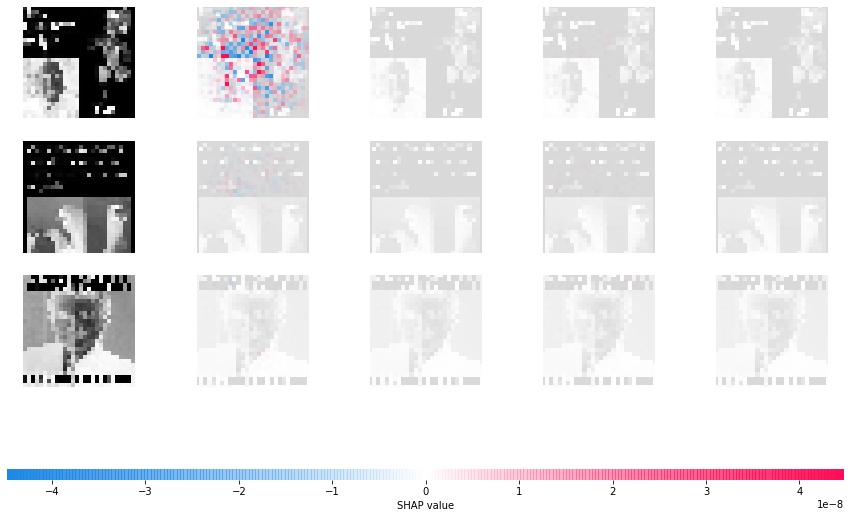

In [22]:
shap.image_plot(shap_numpy, -test_numpy)

In [3]:
tz = BertTokenizer.from_pretrained("bert-base-cased")

In [4]:
class MemesTextDataset(Dataset):
    def __init__(self, annotations_file, tokenizer, label_index=4):
        self.img_labels = pd.read_csv(annotations_file)
        self.tokenizer = tokenizer
        self.label_index = label_index
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
          text = self.img_labels.iloc[idx, 3]
          label = self.img_labels.iloc[idx, self.label_index]
          label = torch.nn.functional.one_hot(torch.tensor(label), num_classes=4)
          return self.tokenizer(text, padding='max_length', truncation=True, return_tensors = 'pt', max_length=100), label
        except Exception as e:
          raise e

In [5]:
meme_ds = MemesTextDataset('/content/memotion_dataset_7k/cleaned_labels.csv', tz, label_index=4)

In [6]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(meme_ds, [0.8, 0.1, 0.1])

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [13]:
l = nn.CrossEntropyLoss()

In [14]:
class Net(torch.nn.Module):
    '''
    Neural Network architecture!
    '''
    def __init__(self, bert, tokenizer, dropout=0.5, clip_len=True, **kw):
        super().__init__(**kw)
        self.bert = bert
        dim = self.bert.config.hidden_size
        self.classifier = torch.nn.Linear(dim, 4)
        
        self.dropout = torch.nn.Dropout(p=dropout)
        self.clip_len = clip_len

        self.tokenizer = tokenizer

    def forward(self, x):       # x: (batsize, seqlen) ints

        bert_outputs = self.bert(x.input_ids.view(x.attention_mask.size(0), x.attention_mask.size(-1)), 
                                 attention_mask=x.attention_mask.view(x.attention_mask.size(0), x.attention_mask.size(-1)), 
                                 output_hidden_states=False)
        lhs = bert_outputs.last_hidden_state[:, 0, :]
        stable_output = self.dropout(lhs)
        logits = self.classifier(stable_output)
        return logits

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = l(output, torch.argmax(target, dim=1))
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += l(output, torch.argmax(target, dim=1)).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(torch.argmax(target, dim=1).view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [15]:
device = torch.device('cuda:0')
num_epochs = 1
bert = BertModel.from_pretrained("bert-base-cased")
model = Net(bert, tz).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

Train Epoch: 1 [0/5581 (0%)]	Loss: 1.395615

Test set: Average loss: 0.0114, Accuracy: 223/697 (32%)



In [30]:
bert.save_pretrained('./trained_model')

In [17]:
df = pd.read_csv('/content/memotion_dataset_7k/cleaned_labels.csv')
df.head()

Unnamed: 0    image_name  \
0           0   image_1.jpg   
1           1  image_2.jpeg   
2           2   image_3.JPG   
3           3   image_4.png   
4           4   image_5.png   

                                            text_ocr  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  The best of #10 YearChallenge! Completed in le...   
2  Sam Thorne @Strippin ( Follow Follow Saw every...   
3              10 Year Challenge - Sweet Dee Edition   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

                                      text_corrected  humour  sarcasm  \
0  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...       3        1   
1  The best of #10 YearChallenge! Completed in le...       0        1   
2  Sam Thorne @Strippin ( Follow Follow Saw every...       2        0   
3              10 Year Challenge - Sweet Dee Edition       2        2   
4  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...       3        3   

   offensive  motivational  overall_sentiment  
0          0             0                  4  
1          0             1                  4  
2          0             0                  3  
3          2             1                  3  
4          2             0                  2

In [31]:
from transformers import AutoModelForSequenceClassification
device = torch.device('cpu')
restored_model = AutoModelForSequenceClassification.from_pretrained("./trained_model", num_labels=4)
pred = pipeline("text-classification", model=restored_model, tokenizer=tz, return_all_scores=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./trained_model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [32]:
explainer = shap.Explainer(pred)

In [33]:
shap_values = explainer(df['text_corrected'][:3])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [02:55<00:00, 36.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 4it [04:21, 87.02s/it]


In [34]:
shap.plots.text(shap_values)